# NLP Sentiment Analysis 

Natural Language Processing (<i>NLP</i>) is an AI technique for extracting information from textual data. One of the most common applications of NLP is that of sentiment analysis, classifying the sentiment of a document as positive or negative. 

It is a challenging problem to do with high accuracy, but there are many packages available that give reasonably good results. The only problem is that we are spoiled for choice. Which is best depends on circumstances.

We can divide solutions to solving sentiment analysis into two categories:

1. [Out-of-the-box solutions](#option1): Use a free Python package and write very few lines of code.
1. [Train your own model](#option2): Again using free packages, you can train your own models using relatively simple algorithms. All the code is here.


## Table of Contents
- [Setup](#Setup)
- [Option 1: Out-of-the-box solutions](#option1)
    - [Afinn](#afinn)
    - [SentiWordNet (NLTK)](#sentiwordnet)
    - [TextBlob (Pattern)](#textblob_pattern)
    - [VADER (NLTK)](#vader)
    - [Summary of the out-of-the-box methods](#oob_summary)
- [Option 2: Train your own model](#option2)
    - [Vectorizers](#vectorizers)
    - [Step-by-step through a simple case](#simple_case)
    - [Try a variety of vectorizers and models](#variety)
- [Results](#results)

## Setup
Packages required for this notebook

In [22]:
!pip3 install --user -U afinn
!pip3 install --user -U sklearn
!pip3 install --user -U nltk
!pip3 install --user -U textblob
!python3 -m textblob.download_corpora lite 

  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/42/ec/32310181e803f5d22e0dd33eb18924489b2f8d08cf5b6e116a93a6a5d1c6/scikit_learn-0.22.2.post1-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c1/60/8cbf00c0deb50a971e6e3a015fb32513960a92867df979870a454481817c/scipy-1.4.1-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/28/5c/cf6a2b65a321c4a209efcdf64c2689efae2cb62661f8f6f4bb28547cf1bf/joblib-0.14.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/52/e6/1715e592ef47f28f3f50065322423bb75619ed2f7c24be86380ecc93503c/numpy-1.18.1-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c5/10/369f50bcd4621b263927b0a1519987a04383d4a98fb10438042ad410cf88/singledispatch-3.4.0.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/eb/1f97cb97bfc2390a276969c6fae16075da282f5058082d4c

In [24]:
import sys
pip3_path = '~/.local/lib/python3.5/site-packages'
pip3_path2 = '~/.local/lib/python3.7/site-packages'
if pip3_path not in sys.path:
    sys.path.append(pip3_path)
if pip3_path2 not in sys.path:
    sys.path.append(pip3_path2)

# general
import sys
import pandas as pd
import numpy as np
import random
import requests
import os
import matplotlib
import matplotlib.pyplot as plt
import tarfile
from zipfile import ZipFile
from time import time
from pprint import pprint
from glob import glob

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn, wordnet as wn
from nltk.stem.lancaster import LancasterStemmer
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('sentiwordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [26]:
# other
#!pip3 install --user -U afinn
from afinn import Afinn
from textblob.en.sentiments import PatternAnalyzer as TextBlobPatternAnalyzer
from textblob.en.sentiments import NaiveBayesAnalyzer as TextBlobNaiveBayesAnalyzer

We will make use of two corpora, one consisting of short documents and one consisting of long documents.

The corpus of short documents contains 3,000 individual sentences taken from reviews on Amazon, Yelp, and IMDB. These are prelabelled with equal numbers of positive and negative sentences. 

The corpus of long documents is a prelabelled set of 25,000 positive and 25,000 negative movie reviews from IMDB.

First, we'll define functions for loading the corpora.

In [28]:
def load_long_docs(max_docs_per_label=np.inf):

    if not os.path.exists('aclImdb_v1.tar.gz'):
        
        print('Downloading long docs...')
        response = requests.get('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')

        with open('aclImdb_v1.tar.gz', 'wb') as f:  
            f.write(response.content)

    else:
        print('Long docs already downloaded.')

    if not os.path.exists('long_docs'):
        
        print('Extracting long docs...')
        with tarfile.open('aclImdb_v1.tar.gz') as tar:
            tar.extractall('long_docs')
            tar.close()

    else:
        print('Long docs already extracted.')


    print('Reading long docs...')

    pos_sentences, neg_sentences = [], []

    count = 0
    for path in glob('long_docs/aclImdb/*/neg/*.txt'):
        with open(path, 'r', errors = "replace") as f:
            text = f.read()
            neg_sentences.append(text)
            count += 1
            if count >= max_docs_per_label:
                break

    count = 0
    for path in glob('long_docs/aclImdb/*/pos/*.txt'):
        with open(path, 'r', errors = "replace") as f:
            text = f.read()
            pos_sentences.append(text)
            count += 1
            if count >= max_docs_per_label:
                break

    return {'pos': pos_sentences, 'neg': neg_sentences}

def load_short_docs():

    if not os.path.exists('short_docs'):
        
        print('Downloading short docs...')
        response = requests.get('http://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment labelled sentences.zip')

        with open('short_docs.zip', 'wb') as f:  
            f.write(response.content)
            
        ZipFile('short_docs.zip').extractall('short_docs')
        print('Short docs downloaded.')
    
    else:

        print('Short docs already downloaded.')
    
    pos_sentences, neg_sentences = [], []

    # pandas.read_csv failed to process one of the files correctly, hence this manual approach.
    for path in glob('short_docs/sentiment labelled sentences/*labelled.txt'): 
        with open(path, 'r') as f:
            pairs = [line.split('\t') for line in f.readlines()]
            for pair in pairs:
                if int(pair[1]):
                    pos_sentences.append(pair[0])
                else:
                    neg_sentences.append(pair[0])

    return {'pos': pos_sentences, 'neg': neg_sentences}

def print_doc_counts(doc_sets):
    
    for key1 in doc_sets:
        for key2 in doc_sets[key1]:
            print(key1, key2, len(doc_sets[key1][key2]))

Next, we'll call our functions to load the long and short corpora. If you have your own corpus readily available, you can add it to the <i>full_doc_sets</i> collection below, and it will automatically be included in the tests that follow.

The long corpus is quite large and takes a long time to train models on. You can choose to load fewer than the 50,000 documents by specifying the optional parameter <i>max_docs_per_label</i>, but you'll also have an option later in the script to train on only a subset of whatever you have downloaded.

In [29]:
full_doc_sets = {'Long': load_long_docs(), # (max_docs_per_label=5000) # optionally, limit size for faster loading
                 'Short': load_short_docs(),
               # 'Your corpus here': {'pos': [...your positive docs...], 'neg': [...your negative docs...]}
                }

doc_set_names = full_doc_sets.keys()

print('Downloads complete.')
print_doc_counts(full_doc_sets)

Extracting long docs...
Reading long docs...
Short docs downloaded.
Downloads complete.
Long pos 25000
Long neg 25000
Short pos 1500
Short neg 1500


For some of our tests, we will use the full document sets, but for others, we need to split them up into training and test sets:

In [30]:
global_results = {}

train_doc_sets = {key: {} for key in full_doc_sets}
test_doc_sets = {key: {} for key in full_doc_sets}

for name in doc_set_names:
    for label in ['pos', 'neg']:
        train, test = train_test_split(full_doc_sets[name][label], test_size=0.2) # do the split
        train_doc_sets[name][label], test_doc_sets[name][label] = train, test

print('Train:')
print_doc_counts(train_doc_sets)
print('Test:')
print_doc_counts(test_doc_sets)

Train:
Long pos 20000
Long neg 20000
Short pos 1200
Short neg 1200
Test:
Long pos 5000
Long neg 5000
Short pos 300
Short neg 300


Before we begin, we need to define some functions that help us test the various solutions we'll be looking at:

In [34]:
def geometric_mean_accuracy(truth, preds):
    
    df = pd.DataFrame(data={'truth': truth, 'preds': preds})
    
    true_pos = sum(df.truth & df.preds)
    true_neg = sum(~df.truth & ~df.preds)
    all_pos = sum(df.truth)
    all_neg = sum(~df.truth)
    
    result = np.sqrt((true_pos / all_pos) * (true_neg / all_neg))
    return result

def print_results(results=global_results, group=None):

    if results is None or len(results) == 0:
        return
    
    df = pd.DataFrame(results).transpose()
    if group is not None:
        df = df[df['_group'] == group]
    df = df.drop('_group', axis=1)
    df = df.reset_index()
    df = df.set_index(['_doc_set', '_method'])
    df = df.rename_axis(('Corpus', 'Method'))
    df = df.drop('index', axis=1)
    df = df.sort_index()
    df = df.astype(float).round(3)
    df['Docs/sec'] = df['Docs/sec'].astype(int)
    df = df[['Accuracy', 'GM accuracy', 'Docs/sec']]
    
    display(df)

def build_result(group, method, doc_set_name, start, stop, truth, preds):

    key = '{}_{}_{}'.format(method, group, doc_set_name)
    
    result = {key : {'_group': group, 
                     '_method': method,
                     '_doc_set': doc_set_name,
                     'GM accuracy': None if truth is None else geometric_mean_accuracy(truth, preds),
                     'Accuracy': None if truth is None else accuracy_score(truth, preds),
                     'Docs/sec': None if truth is None else len(truth) / (stop - start),
                   # 'Your measurement': ...
                    }}
    
    global_results.update(result)
    return result
    
def run_test(group, method, doc_sets, func, max_records_per_label=np.nan):
    
    local_results = {}
    
    for doc_set_name, doc_set in doc_sets.items():
        
        pos_docs, neg_docs = doc_set['pos'], doc_set['neg']
        if len(pos_docs) > max_records_per_label:
            pos_docs = random.sample(pos_docs, max_records_per_label)
        if len(neg_docs) > max_records_per_label:
            neg_docs = random.sample(neg_docs, max_records_per_label)

        start = time()
        preds = [func(doc) for doc in pos_docs + neg_docs]
        stop = time()

        truth = [True] * len(pos_docs) + [False] * len(neg_docs)
        
        result = build_result(group, method, doc_set_name, start, stop, truth, preds)
        local_results.update(result)
    
    print_results(local_results, group=group)
    
def plot_results(group, var_names=None, title='', round_digits=0, relative=False, lower_limit=None, upper_limit=None):

    for doc_set_name in sorted(doc_set_names):

        df = pd.DataFrame(global_results).transpose()
        df = df[df._doc_set == doc_set_name]
        df = df[df._group == group]
        if len(df) == 0:
            print('No results.')
            return
        
        if var_names is None:
            var_names = [x for x in df.columns if not x.startswith('_')]

        df = df.sort_index(ascending=False)
        methods = df._method.values
        df = df[list(reversed(var_names))]
        orig_df = df.copy() # the dataframe may get scaled so we need to preserve the original values

        lower_limit_, upper_limit_ = lower_limit, upper_limit
        if relative:
            df = df / df.max()
            lower_limit_ = 0
            upper_limit_ = 1.1
        else:
            lower_limit_ = df.values.min() * 0.9 if lower_limit is None else lower_limit
            upper_limit_ = df.values.max() * 1.15 if upper_limit is None else upper_limit

        positions = np.arange(len(df.columns))
        bars_per_bar_group = len(df)
        bar_width = 0.8 / bars_per_bar_group
        bar_start = -bars_per_bar_group / 2 + 0.5

        fig, ax = plt.subplots(figsize = [10, df.size * .3 + .3])
        plt.title("{} (Group='{}', Corpus='{}')".format(title, group, doc_set_name), fontsize=14)
        bar_pos = bar_start

        min_value, max_value = float('inf'), float('-inf')
        for i, col in enumerate(df.index.values):
            bar = ax.barh(positions + bar_pos * bar_width, df.loc[col, :], bar_width, label=' '+methods[i])
            for rect, value in zip(bar, orig_df.loc[col, :]):
                if round_digits == 0:
                    value = int(value)
                else:
                    value = round(value, round_digits)
                ax.text(rect.get_x() + rect.get_width(), rect.get_y() + rect.get_height() / 2,
                        ' ' + str(value), ha='left', va='center', color='black', weight='medium')
            bar_pos += 1

        ax.set_yticks(range(len(df.columns)))
        ax.set_yticklabels(df.columns.values)
        ax.set_xlim([lower_limit_, upper_limit_])
        if relative:
            ax.set_xticks([])
            ax.set_xticklabels([])
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

## Option 1: Out-of-the-box solutions<a id='option1'></a>

The first option is the simplest with most solutions requiring only a single line of code to classify a document. These are appropriate choices for quick experimentation, or when your corpus is not large enough for training your own model.

We limited our investigation to Python packages with straightforward <i>pip</i> installations and no special dependencies. Also, the packages had to be free and licensing had to be very permissive. We will test run quality tests and report the results in terms of accuracy (a simple mean of correctness) and geometric mean accuracy (<i>GM accuracy</i>).

We use the geometric mean because our classes are balanced, and positive and negative classes are treated as equals. There is no implicit <i>positive</i> label in the sense that we would use to describe a medical diagnosis. Therefore, typical measures that attempt to compensate for class imbalance don't translate very well to our situation. The geometric mean is close to the arithmetic mean, but gives greater emphasis to the lower score of the two classes. If the accuracy and the geometric mean accuracy are far apart, then our results are biased and that gets penalized in the geometric mean.

Some sentiment analysis packages also provide a score on another axis: <i>subjectivty</i> vs. <i>objectivity</i>. This can be useful to the caller because objective statements don't have much sentiment; they should be somewhat neutral. We can use this fact to improve our results from SentiWordNet, discussed below.

## Afinn<a id='afinn'></a>
The Afinn package for Python wraps the AFINN sentiment lexicon which contains 3382 words manually tagged by researcher Finn Årup Nielsen. Afinn has an Apache 2.0 license. You, "as a scientist", should cite:

- Finn Årup Nielsen, “A new ANEW: evaluation of a word list for sentiment analysis in microblogs”, Proceedings of the ESWC2011 Workshop on ‘Making Sense of Microposts’: Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)

https://arxiv.org/abs/1103.2903

https://medium.com/@himanshu_23732/sentiment-analysis-with-afinn-lexicon-930533dfe75b

As Afinn is the first package we are looking at, let's first try it out on a couple of examples. We see a positive number for positive sentiment and a negative number for negative sentiment:

In [31]:
af = Afinn()
print(af.score("What a miserable waste of time."))
print(af.score("Brilliant!"))

-4.0
4.0


And here are a couple of sentences that aren't always so easy for sentiment analysis tools. You can see that the results are mixed:

In [32]:
print(af.score("It was not good."))
print(af.score("In your dreams was it worth the money."))

-2.0
3.0


Let's test Afinn against our corpus. The final parameter is the number of documents to sample. You can omit that if you want to test against the whole corpus, but be prepared to wait.

In [35]:
af = Afinn()

run_test('Out of the box', 'Afinn', full_doc_sets, lambda x: af.score(x) > 0, max_records_per_label=2500)

,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,Afinn,0.714,0.702,131
Short,Afinn,0.780,0.780,2574


Note that you can also use VADER via the vaderSentiment package. We received identical scores from vaderSentiment and NLTK's implementation, but NLTK's was faster so is the only example included here.

### SentiWordNet (NLTK)<a id='sentiwordnet'></a>

<a href='http://nmis.isti.cnr.it/sebastiani/Publications/LREC10.pdf'>SentiWordNet</a>, also made available via NLTK, is built on the <a href='https://wordnet.princeton.edu/'><i>WordNet</i></a> lexicon, with positive and negative scores mechanically generated for each word. Though it is made available through the NLTK API, one could argue that it falls just slightly short of being 'out-of-the-box' because aggregation of individual word scores is the caller's responsibility, but the code is simple enough. In this code example, we take into account that SentiWordNext actually does ternary classifcation using a third category, objectivity, which is neither positive nor negative. Here, we take the positive score minus the negative score, and then multiple that by the amount of subjectivity (1 minus the objectivity) to determine the sentiment of each word. We sum the resulting word scores to determine the polarity of a document. A different aggregation formula could certainly be used.

https://www.researchgate.net/publication/220746537

In [36]:
def score_sentiwordnet(doc):
    
    synsets = (wn.synsets(w) for w in word_tokenize(doc) if w is not None) # tokenize and lookup synonyms in WordNet
    words = (s[0].name() for s in synsets if s is not None and len(s) > 0) # use the first (most common) synonym
    words = (swn.senti_synset(s) for s in words) # get sentiment scores which have pos, neg, and neutral parts
    scores = ((1 - w.obj_score()) * (w.pos_score() - w.neg_score()) for w in words) # calculate individual word scores
    return (sum(scores) > 0) # classify document as positive if resulting score is positive

run_test('Out of the box', 'SentiWordNet', full_doc_sets, lambda x: score_sentiwordnet(x), max_records_per_label=2500)

,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,SentiWordNet,0.662,0.651,114
Short,SentiWordNet,0.674,0.673,2270


### TextBlob (Pattern)<a id='textblob_pattern'></a>

<a href='https://textblob.readthedocs.io/en/dev/'>TextBlob</a> implements a variety of NLP functionality, including two modules for sentiment analysis. The one we look at here, <i>PatternAnalyzer</i>, provides an implemetation of <a href='https://www.clips.uantwerpen.be/pattern'>Pattern</a>, a web-mining tool from CLiPS, the Computational Linguistics and Psycholinguistics Research Center in Belgium. It bases polarity scores on hand-tagged and inferred sentiments in an internal
lexicon. The other module provided by TextBlob is a Naive Bayes classifier that performed poorly in our tests.

https://textblob.readthedocs.io/en/dev/

https://www.clips.uantwerpen.be/pattern

In [37]:
pa = TextBlobPatternAnalyzer()

run_test('Out of the box', 'TextBlob (Pattern)', full_doc_sets, lambda x: pa.analyze(x)[0] > 0, max_records_per_label=2500)

,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,TextBlob (Pattern),0.684,0.635,673
Short,TextBlob (Pattern),0.778,0.778,5144


### VADER (NLTK)<a id='vader'></a>
Natural Language Toolkit (<a href='https://www.nltk.org/'>NLTK</a>) has been a Python standard for many years and continues to be updated. NLTK supports an extensive variety of NLP functionality and gives easy API access for downloading various corpora.

NLTK supports sentiment analysis by way of two methods. The first we will look at is <i>VADER</i>, the Valence Aware Dictionary and sEntiment Reasoner. VADER specializes in social media text meaning that it is well-suited to text containing slang, emoticons, emojis, capitalization, and meaningful punctuation such as exclamation marks. It uses rules and an internal lexicon, manually labelled using Amazon Mechanical Turk, to generate polarity scores. NLTK is open-sourced and under an Apache 2.0 license. Use of the VADER lexicon requires you (and us) to cite this paper:
- <a href='http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf'>Hutto, C.J. & Gilbert, E.E. (2014)</a>. VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [38]:
sia = SentimentIntensityAnalyzer()

run_test('Out of the box', 'VADER', full_doc_sets, lambda x: sia.polarity_scores(x)['compound'] > 0, max_records_per_label=2500)

,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,VADER,0.699,0.681,361
Short,VADER,0.811,0.811,6205


### Summary of the out-of-the-box methods<a id='oob_summary'></a>


In [39]:
print_results()

Accuracy  GM accuracy  Docs/sec
Corpus Method                                             
Long   Afinn                  0.714        0.702       131
       SentiWordNet           0.662        0.651       114
       TextBlob (Pattern)     0.684        0.635       673
       VADER                  0.699        0.681       361
Short  Afinn                  0.780        0.780      2574
       SentiWordNet           0.674        0.673      2270
       TextBlob (Pattern)     0.778        0.778      5144
       VADER                  0.811        0.811      6205

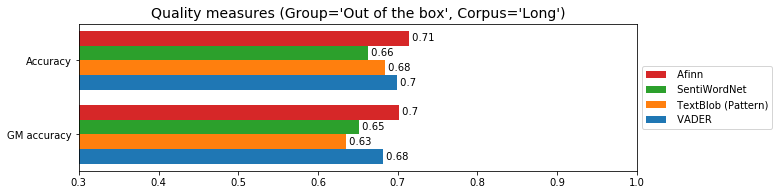

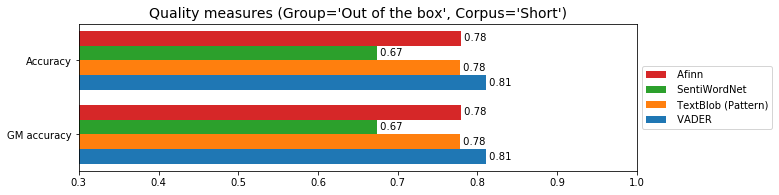

In [40]:
plot_results('Out of the box', var_names=['Accuracy', 'GM accuracy'], title='Quality measures', round_digits=2,
             lower_limit=0.3, upper_limit=1.0)

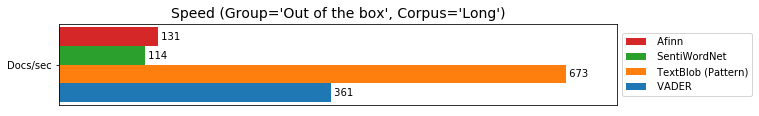

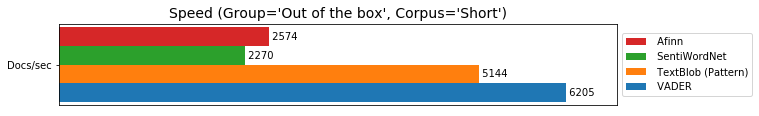

In [41]:
plot_results('Out of the box', var_names=['Docs/sec'], title='Speed', relative=True,
             lower_limit=0.3, upper_limit=1.0)

Results will not match ours exactly. The test/train splits are random and different every time, and you may not have chosen to use the entire corpus of long documents. But most likely you will also see that VADER (via the NLTK API) appears to be the overall winner, though Afinn had slightly higher accuracy on the long corpus. The table below gives a quick summary of some of the characteristics and results of each method:

|&nbsp;|Afinn|SentiWordNet (NLTK)|TextBlob (Pattern)|VADER (NLTK)|
|:------|:------|:------|:------|:------|
| Lexicon | yes, internal | WordNet | yes, internal | yes, internal |
| Mechanism  | hand-tagged  | clustering mechanism,<br />synsets | hang-tagged and<br />inferred polarities | hand-tagged using<br />'wisdom of the crowd' |
| License  | Apache 2.0  | Apache 2.0  | permissive | NLTK: Apache 2.0,<br />VADER: MIT |
| Citation responsibility<br />in some circumstances | yes | no | no | yes |
| Also provides subjectivity-<br />objectivity scale | no |no |yes |no |
| Notes |one of two most accurate,<br />relatively slow | not the simplest API,<br />caller must aggregate<br />word scores |tuned for social media,<br />fastest on longer documents | one of the two most accurate,<br />fastest for shorter docs |

## Option 2: Train your own model<a id='option2'></a>
To train a model for text classification, we must first do some specialized feature engineering to highlight useful elements within this relatively unstructured data. Sophisticated approaches will do a full linguistic and semantic analysis of a document and build features from that structure. We will see how far we can get with a simpler approach.

Our feature engineering will be based on counts of unique words, the idea being that the use of certain words is indicative of positive or negative sentiment. We will generate a vector of word counts for each document, with each position in the vector representing one unique word. Generating these vectors is done by <i>vectorizers</i>. We will look at two of them. 
- <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html'>CountVectorizer</a>
- <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html'>TfidfVectorizer</a>

After vectorizing the text, we can then use any machine learning algorithm we choose. Here, just to try a few, we shall use:
- <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>Naive Bayes</a>
- <a href='https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'>Logistic Regression</a>
- <a href='https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html'>Support Vector Machine (with a linear kernel)</a>

Note that <i>positive</i> and <i>negative</i> are just class labels. We could classify text along any axis we wish, <i>passive</i> vs. <i>active</i>, <i>dominant</i> vs. <i>submissive</i>, etc., as long as we have the appropriate labels for our training data. Also, we do not have to limit ourselves to binary choices, although doing so could affect our model choice.

### Vectorizers<a id='vectorizers'></a>
#### Using raw counts

<i>CountVectorizer</i> simply counts each unique word. In this example, we fit the vectorizer to a very small corpus.

In [42]:
corpus = ['The dog', 'The person', 'The cat']

count_vectorizer = CountVectorizer()
count_vectorizer.fit(corpus)

print(count_vectorizer.get_feature_names())
print(count_vectorizer.transform(corpus).toarray())

['cat', 'dog', 'person', 'the']
[[0 1 0 1]
 [0 0 1 1]
 [1 0 0 1]]


Now we can build a vector from a previously unseen document. Words that were not seen in the corpus are ignored.

In [43]:
test_set = ['The one cat', 'Person dog person']

print(count_vectorizer.get_feature_names())
print(count_vectorizer.transform(test_set).toarray())

['cat', 'dog', 'person', 'the']
[[1 0 0 1]
 [0 1 2 0]]


The following diagram illustrates the roles of the vectorizer and the model with respect to the corpus and the test set:

![count vectorizer](https://storage.googleapis.com/kf-pipeline-contrib-public/release-0.1.3/kfp-components/notebooks/nlp_sentiment_analysis/assets/count_vectorizer.png)

#### Using TF-IDF
The <i>TF-IDF</i> approach, implemented in <i>TfidfVectorizer</i>, puts greater emphasizes on words that appear less frequently in the corpus, and are therefore more likely to be hold specific meaning. The acronym standas for <i>term frequency-inverse document frequency</i> because the resulting value is positively related to the frequency of the term in a document, but inversely related to its frequency in the training corpus. The most common words, such as <i>the</i>, typically hold the least meaning.

Let's fit a <i>TfidfVectorizer</i>:

In [45]:
corpus = ['The dog', 'The person', 'The cat']

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(corpus)

print(tfidf_vectorizer.get_feature_names())
print(tfidf_vectorizer.transform(corpus).toarray().round(3))

['cat', 'dog', 'person', 'the']
[[0.    0.861 0.    0.509]
 [0.    0.    0.861 0.509]
 [0.861 0.    0.    0.509]]


See, in the first document, that 'cat' is weighted more heavily than 'the' despite appearing the same number of times.

In [46]:
test_set = ['The one cat', 'A person and a dog person']

print(tfidf_vectorizer.get_feature_names())
print(tfidf_vectorizer.transform(test_set).toarray().round(3))

['cat', 'dog', 'person', 'the']
[[0.861 0.    0.    0.509]
 [0.    0.447 0.894 0.   ]]


And the equivalent diagram for TF-IDF:
    
![TF-IDF vectorizer](https://storage.googleapis.com/kf-pipeline-contrib-public/release-0.1.3/kfp-components/notebooks/nlp_sentiment_analysis/assets/tfidf_vectorizer.png)

### Step-by-step through a simple case<a id='simple_case'></a>
Now let's use a vectorizer to help us build a working model from a more substantial corpus. We will walk through the simplest possible model quickly and with minimal explanation, just enough to set up the discussion to follow.

First, create the vectorizer and fit it to our training set. That means it will identify unique words in the corpus and assign each a position in our future vectors. Then, in the same call, have it transform the training documents into vectors that we will use as inputs to our algorithm:

In [47]:
tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(train_doc_sets['Short']['pos'] + train_doc_sets['Short']['neg'])

Let's take a look at a few of the features identified by the vectorizer and then see their TF-IDF values for a piece of text:

In [48]:
print(tfidf_vectorizer.get_feature_names()[-5:])
print(tfidf_vectorizer.transform(['zillion zillion zombie']).toarray()[0][-5:].round(3))

['yummy', 'z500a', 'zero', 'zillion', 'zombie']
[0.    0.    0.    0.903 0.429]


We can see the relative relationship between the values of 'zillion' and 'zombie' based on their <i>term frequency</i> within the text, but neither are very common words. Let's try adding a common word to see how its low <i>inverse document frequency</i> reduces its impact:

In [49]:
v = tfidf_vectorizer.transform(['the zillion zillion zombie']).toarray()
v = v[v > 0.0]
print(v.round(3))

[0.101 0.899 0.427]


Determine the labels for our data. This is easy because we've kept them in separate lists.

In [50]:
y_train = [1] * len(train_doc_sets['Short']['pos']) + [0] * len(train_doc_sets['Short']['neg'])

Create and fit a Naive Bayes model to the word counts in the training set:

In [51]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Transform our test documents into feature vectors:

In [52]:
X_test = tfidf_vectorizer.transform(test_doc_sets['Short']['pos'] + test_doc_sets['Short']['neg'])

Generate predictions from our test data. We take our feature vectors and predict a class, <i>'pos'</i> or <i>'neg'</i>:

In [53]:
y_preds = model.predict(X_test)

Score our predictions against the true labels for our test set. The result is surprisingly good for such a simple approach.

In [54]:
y_truth = [1] * len(test_doc_sets['Short']['pos']) + [0] * len(test_doc_sets['Short']['neg'])
print(accuracy_score(y_truth, y_preds).round(3))

0.832


### Try a variety of vectorizers and models<a id='variety'></a>

We'll define a few functions that will help us run through the same steps as we just did, but in a more flexible and repeatable manner while enabling us to choose (or write) our own vectorizers and algorithms. You can ignore the content of these functions unless you want to do any fine-tuning.

In [55]:
def flex_train(doc_set_name, vectorizer, model, max_train_docs_per_label):

    pos_docs = train_doc_sets[doc_set_name]['pos']
    neg_docs = train_doc_sets[doc_set_name]['neg']

    if len(pos_docs) > max_train_docs_per_label:
        pos_docs = pos_docs[:max_train_docs_per_label]
    if len(neg_docs) > max_train_docs_per_label:
        neg_docs = neg_docs[:max_train_docs_per_label]

    X = np.abs(vectorizer.fit_transform(pos_docs + neg_docs))
    y = [True] * len(pos_docs) + [False] * len(neg_docs)

    model.fit(X, y)

def flex_predict(vectorizer, model, docs):

    X = np.abs(vectorizer.transform(docs))
    preds = model.predict(X)
    return preds

def flex_test(group, method, doc_set_name, vectorizer, model):

    pos_docs = test_doc_sets[doc_set_name]['pos']
    neg_docs = test_doc_sets[doc_set_name]['neg']

    truth = [True] * len(pos_docs) + [False] * len(neg_docs)
    
    start = time()
    preds = flex_predict(vectorizer, model, pos_docs + neg_docs)
    stop = time()

    return build_result(group, method, doc_set_name, start, stop, truth, preds)

def flex_train_and_test(group, method, vectorizer, model, max_train_docs_per_label=np.inf):

    local_results = {}
    
    for doc_set_name in doc_set_names:

        flex_train(doc_set_name, vectorizer, model, max_train_docs_per_label)
        result = flex_test(group, method, doc_set_name, vectorizer, model)
        local_results.update(result)
        global_results.update(result)
        
    return local_results

Now, with one line of code, we can perform the same task as our more granular walk-through above, but we'll do so on both of our defined corpora and give more detailed results. We will again use a <i>TfidfVectorizer</i> with a Naive Bayes model:

In [56]:
print_results(flex_train_and_test('Self-trained', 'TF-IDF + NB', TfidfVectorizer(),
                                  MultinomialNB(), max_train_docs_per_label=1000))

,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,TF-IDF + NB,0.812,0.807,4550
Short,TF-IDF + NB,0.828,0.828,61507


Of course, we can tune the vectorizer and/or model with specific parameters. Here we will create a <i>TfidfVectorizer</i> that counts not only individual terms, but also bigrams and trigrams. <i>Bigrams</i> and <i>trigrams</i> are sequences of two and three terms, respectively, appearing consecutively in the text. We also specify that we want to use the <i>sublinear</i> term frequency which softens the impact of terms that appear a large number of times by using a logarithm of the term counts instead of the raw values. This made a noticeable improvement:

In [57]:
print_results(flex_train_and_test('Self-trained', 'TF-IDF + NB', TfidfVectorizer(ngram_range=(1, 3), sublinear_tf=True),
                                  MultinomialNB(), max_train_docs_per_label=1000))

,,Accuracy,GM accuracy,Docs/sec
Corpus,Method,,,
Long,TF-IDF + NB,0.840,0.837,1424
Short,TF-IDF + NB,0.818,0.818,28502


Now, let's do a grid search of some vectorizers and algorithms. A <i>grid search</i> involves exhaustively trying all combinations of a set of discrete options such as hyperparameters or algorithms to find the best combination.

First, we'll define a function to mechanically run the grid search for us:

In [58]:
def grid_search(group, max_train_docs_per_label=np.inf):

    i = 0
    vectorizers = get_vectorizers()
    for v_name, v in vectorizers.items():

        models = get_models()
        for m_name, m in models.items():

            method = v_name + ' + ' + m_name
            i += 1
                
            print('Processing {} of {}: {} ...'.format(i, len(vectorizers) * len(models), method))
            flex_train_and_test(group, method, v, m, max_train_docs_per_label)
    
    print_results(group=group)

Now we'll define functions to create our candidates for the grid search. We use functions to generate our objects as opposed to simply defining variables to ensure that we do not accidentally reuse objects and pollute our results. Feel free to add your own vectorizers and models to the dictionaries returned by these functions.

We'll use both types of vectorizers that we have discussed thus far. As for algorithms, we'll try out Naive Bayes, Logistic Regression, and a linear Support Vector Machine.

In [59]:
def get_vectorizers():
    
    return {'Count': CountVectorizer(ngram_range=(1, 3)),
            'TF-IDF': TfidfVectorizer(ngram_range=(1, 3), sublinear_tf=True),
          # 'Your vectorizer': YourVectorizer()
           }

def get_models():

    return {'NB': MultinomialNB(),
            'LogR': LogisticRegression(),
            'LinSVM': LinearSVC(),
          # 'Your Model': YourModel()  
           }

In this step, we will perform the grid search. In the interests of time, we've limited the number of training documents to 2500. Feel free to change that number using the parameter <i>max_train_docs_per_label</i> in the call below. You can also remove the parameter to use the full training set, though doing so could cause this cell to take a long time to execute, perhaps one to two hours.

You may encounter a couple of warnings relating to a failure to converge. For demonstration purposes, these warnings can be ignored. For more robust results, you may wish to set the appropriate parameters on the models in the code cell above to ensure convergence.

In [60]:
grid_search('Self-trained', max_train_docs_per_label=2500)

Processing 1 of 6: Count + NB ...
Processing 2 of 6: Count + LogR ...


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Processing 3 of 6: Count + LinSVM ...


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Processing 4 of 6: TF-IDF + NB ...
Processing 5 of 6: TF-IDF + LogR ...
Processing 6 of 6: TF-IDF + LinSVM ...


Accuracy  GM accuracy  Docs/sec
Corpus Method                                          
Long   Count + LinSVM      0.865        0.865      1368
       Count + LogR        0.865        0.865      1337
       Count + NB          0.858        0.858      1384
       TF-IDF + LinSVM     0.877        0.877      1245
       TF-IDF + LogR       0.860        0.859      1232
       TF-IDF + NB         0.862        0.861      1276
Short  Count + LinSVM      0.848        0.848     31699
       Count + LogR        0.845        0.845     23621
       Count + NB          0.823        0.823     30099
       TF-IDF + LinSVM     0.845        0.845     29285
       TF-IDF + LogR       0.825        0.825     21498
       TF-IDF + NB         0.825        0.825     26430

On the full corpus, without limiting the number of training documents, the author obtained accuracies of just over 90%.

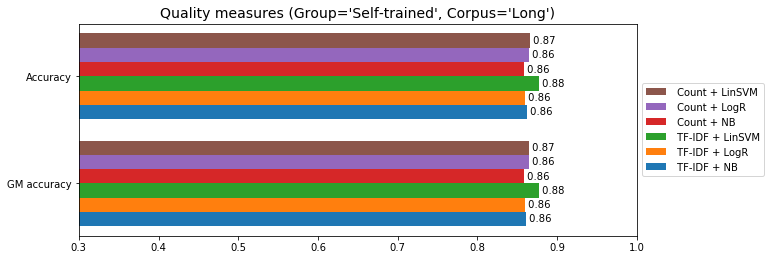

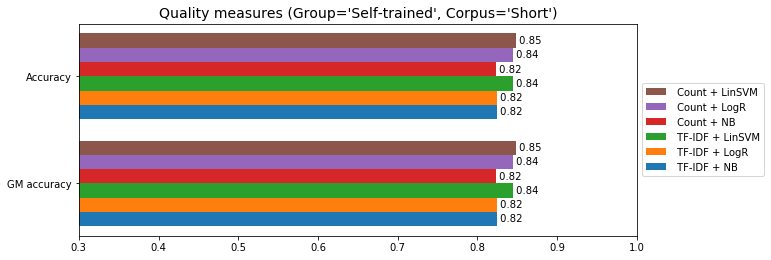

In [61]:
plot_results(group='Self-trained', var_names=['Accuracy', 'GM accuracy'], title='Quality measures', round_digits=2,
             lower_limit=0.3, upper_limit=1.0)

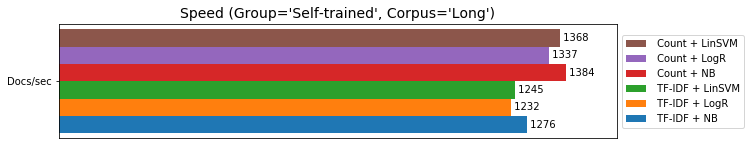

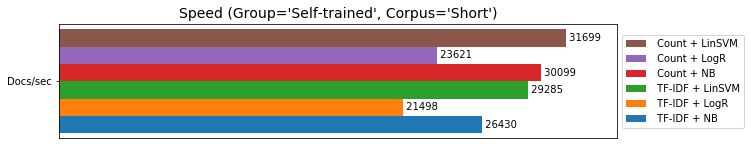

In [62]:
plot_results(group='Self-trained', var_names=['Docs/sec'], title='Speed', relative=True)

## Results and summary<a id='results'></a>

Below we see the most important statistics for all of our tests, including the out-of-the-box solutions:

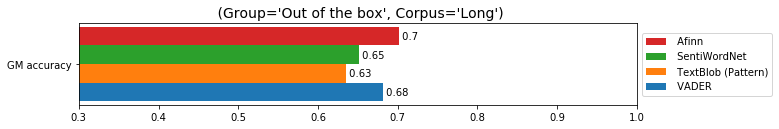

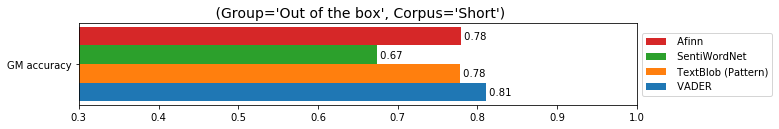

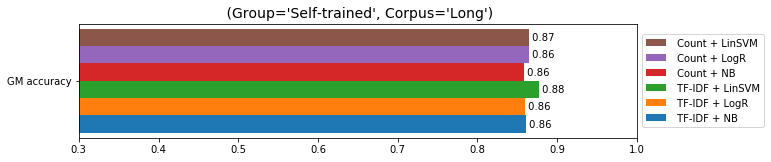

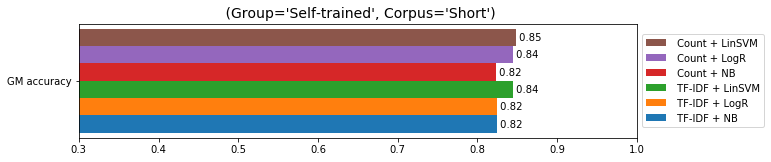

In [63]:
plot_results('Out of the box', var_names=['GM accuracy'], title='', round_digits=2,
             lower_limit=0.3, upper_limit=1.0)
plot_results(group='Self-trained', var_names=['GM accuracy'], title='', round_digits=2,
             lower_limit=0.3, upper_limit=1.0)

On the long corpus, our self-trained models performed far better than the out-of-the-box solutions. They also ran much faster.

On the short corpus, with both fewer and shorter documents, there was a modest, but not overwhelming, benefit to our best self-trained models over the better out-of-the-box solutions.

The best combination of vectorizer and model appeared to be TF-IDF and the linear Support Vector Machine.

Again, the bottom line is that it all depends on circumstances and how the various options perform on your corpus specifically. The best solution is often the simplest, but in this case, it appears that training our own corpus is well worth the extra effort.